In [1]:
import os
import glob
import dask
import numpy as np
import xarray as xr
import cftime
import pop_tools
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib as mpl
import pandas as p

# Prepare time series to visualise 

In [3]:
def standardise_time(ds):
    decoded = xr.decode_cf(ds, use_cftime=True)
    if isinstance(decoded.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in decoded.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

# Define region-specific masks
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [200.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [260.0, 360.0]}}
    ]
}

# Create mask for selected regions
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')

# Define path and files pattern for temperature and salinity data
path = '/Data/skd/scratch/innag3580/comp/averages/'
temp_files_pattern = 'TEMP_*.nc'
salt_files_pattern = 'SALT_*.nc'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
temp_file_list = sorted(glob.glob(os.path.join(path, temp_files_pattern)))
ds_temp = xr.open_mfdataset(temp_file_list, chunks={'time': 120}, preprocess=standardise_time)
ds_temp['TEMP'] = ds_temp['TEMP'].astype('float32')
ds_temp = ds_temp.where(mask == 1).resample(time='1Y').mean()

In [5]:
salt_file_list = sorted(glob.glob(os.path.join(path, salt_files_pattern)))
ds_salt = xr.open_mfdataset(salt_file_list, chunks={'time': 120}, preprocess=standardise_time)
ds_salt['SALT'] = ds_salt['SALT'].astype('float32')
ds_salt = ds_salt.where(mask == 1).resample(time='1Y').mean()

# choose historic time perios
ds_temp = ds_temp.isel(time=slice(0,164))
ds_salt = ds_salt.isel(time=slice(0,164))

In [6]:
# Define physical constants
rho_sw = 1026  # density of seawater in kg/m^3
cp_sw = 3990  # specific heat of seawater in J/(kg·K)

# Convert units to meters and square meters
ds_salt['dz'] = ds_temp.dz * 1e-2
ds_temp['UAREA'] = ds_temp.UAREA * 1e-4

# Define reference salinity
S_ref = 35  # PSU

# Convert units to meters and square meters
ds_salt['dz'] = ds_salt.dz * 1e-2
ds_salt['UAREA'] = ds_salt.UAREA * 1e-4

In [7]:
# Compute heat content
heat_content = rho_sw * cp_sw * (ds_temp.dz * ds_temp.UAREA * ds_temp.TEMP).sum(dim=['nlat', 'nlon', 'z_t'])

# Freshwater content computation (add this line)
freshwater_content = ((S_ref - ds_salt.SALT) / S_ref * ds_salt.dz * ds_salt.UAREA).sum(dim=['nlat', 'nlon', 'z_t'])

## load smoc time series

In [8]:
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'
output = os.path.join(output_dir, 'smoc55_ensemble_mean.nc')
smoc55 = xr.open_dataarray(output).resample(time='1Y').mean().isel(time=slice(0,164))

In [ ]:
smoc55.plot()

## Plot Total Heat and Freshwater Content in the SPNA

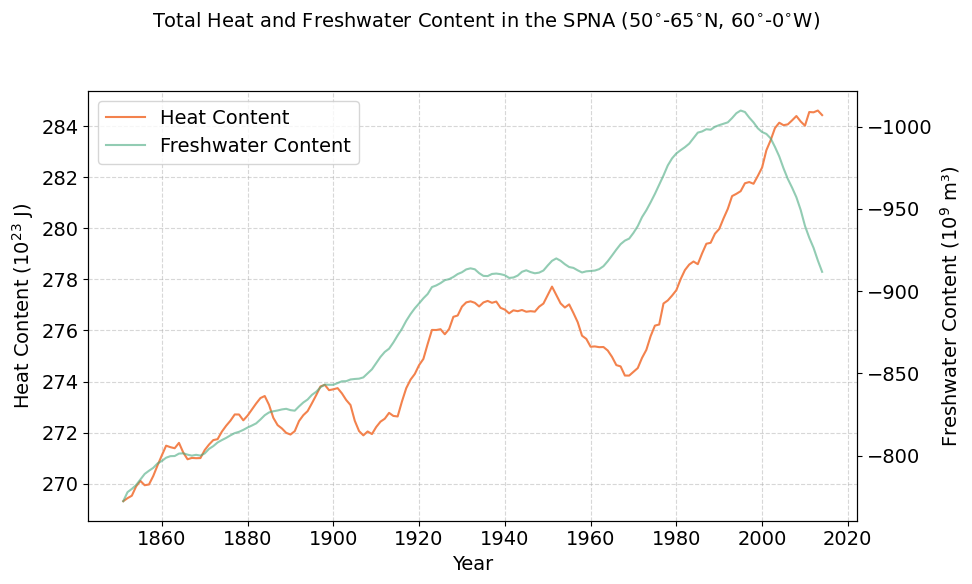

In [14]:
# Define a consistent font size
fontsize = 14

# Define the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot heat content time series
ax1.plot(heat_content.time, heat_content / 1e23, color=cmo.thermal(0.7), label='Heat Content')
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('Heat Content ($10^{23}$ J)', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Twin axis for freshwater content and flip y-axis
ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.plot(freshwater_content.time, freshwater_content / 1e9, color=cmo.haline(0.6), label='Freshwater Content', alpha=0.6)
ax2.set_ylabel('Freshwater Content ($10^9$ m³)', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=fontsize)

# Title
fig.suptitle(r'Total Heat and Freshwater Content in the SPNA (50$^{\circ}$-65$^{\circ}$N, 60$^{\circ}$-0$^{\circ}$W)', fontsize=fontsize)

# Grid and Layout
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
#plt.savefig('Figure_freshwater_and_heat.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

## Plot Heat and Freshwater Content in the SPNA Relative change to initial 40 years

In [9]:
delta_heat_content = (heat_content - heat_content.isel(time=slice(0,164)).mean('time')) / heat_content.isel(time=slice(0,164)).mean('time')
delta_freshwater_content = (freshwater_content - freshwater_content.isel(time=slice(0,164)).mean('time')) / freshwater_content.isel(time=slice(0,164)).mean('time')
delta_smoc55 = (smoc55 - smoc55.isel(time=slice(0,164)).mean('time')) / smoc55.isel(time=slice(0,164)).mean('time')

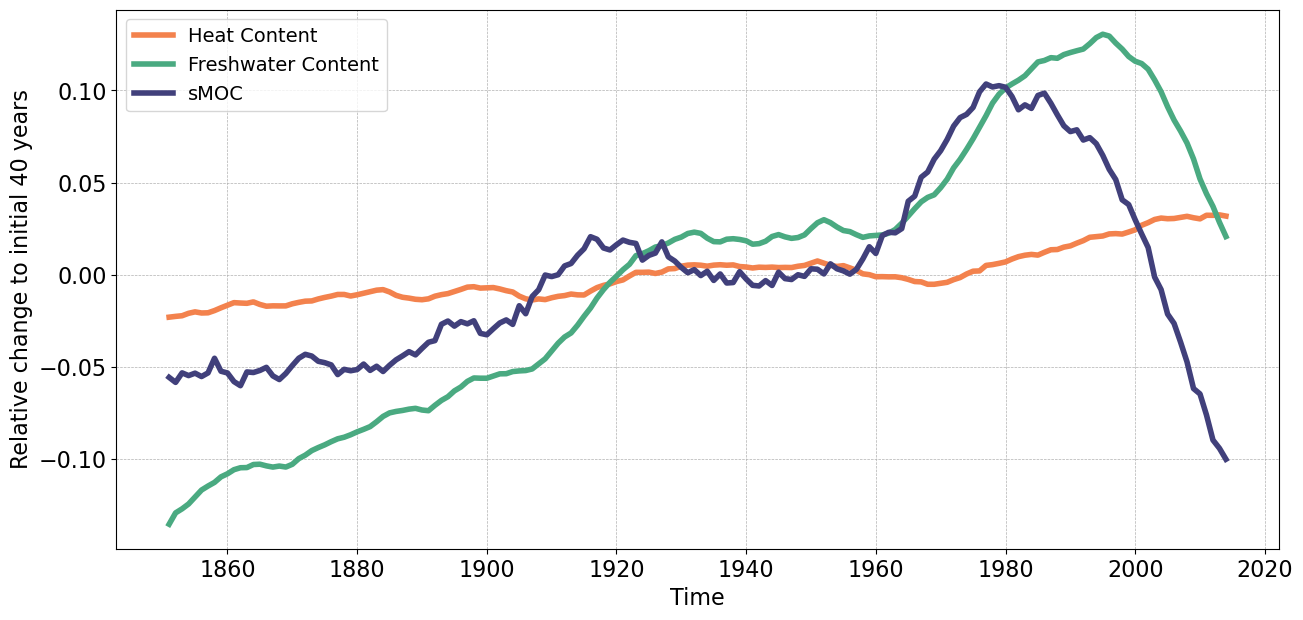

In [11]:
# Configure colors using cmocean colormap
colors = {
    'delta_heat_content': cmo.thermal(0.7),  # Using thermal colormap
    'delta_freshwater_content': cmo.haline(0.6),  # Using haline colormap
    'delta_smoc55': cmo.deep(0.8),
}

# Plotting using xarray
fig, ax = plt.subplots(figsize=(15, 7))
plt.rc('font', size=16)

# Plot the data
ax.plot(delta_heat_content.time+1, delta_heat_content, linewidth=4, color=colors['delta_heat_content'], label='Heat Content')
ax.plot(delta_freshwater_content.time+1, delta_freshwater_content, linewidth=4, color=colors['delta_freshwater_content'], label='Freshwater Content')
ax.plot(delta_smoc55.time+1, delta_smoc55, linewidth=4, color=colors['delta_smoc55'], label='sMOC')

# Highlight ranges of time
#ax.set_xlim(20, 60)

# Set labels and grid for publication quality
ax.set_ylabel('Relative change to initial 40 years')
ax.set_xlabel('Time')
ax.grid(visible=True, linestyle='--', linewidth=0.5)
ax.legend(loc='upper left', fontsize=14, frameon=True)

# No title as requested
plt.show()